In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits import axes_grid1
import nibabel as nib
import numpy as np
import pandas as pd
from scipy import stats
from nilearn import datasets
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from niworkflows_plots import fMRIPlot

In [2]:
def get_fd(motion):
    # assuming rotations in degrees
    motion = np.vstack((np.array([[0, 0, 0, 0, 0, 0]]),
                        np.diff(motion, axis=0)))
    fd = np.sum(np.abs(motion), axis=1)
    return fd

In [3]:
get_data = False

if get_data:
    mask_img = datasets.load_mni152_brain_mask()
    subjects = datasets.fetch_adhd(n_subjects=3)
    subj_idx = 2
    df = pd.read_csv(subjects.confounds[subj_idx], sep='\t')
    conf_df = df[['motion-pitch', 'motion-roll', 'motion-yaw',
                  'motion-x', 'motion-y', 'motion-z']]
    conf_df = conf_df.rename(columns={'motion-x': 'X',
                                      'motion-y': 'Y',
                                      'motion-z': 'Z',
                                      'motion-pitch': 'P',
                                      'motion-roll': 'R',
                                      'motion-yaw': 'Ya'})
    conf_df[['R', 'P', 'Ya']] = conf_df[['R', 'P', 'Ya']] * 50 * (np.pi/180.)
    motion = conf_df.values
    conf_df['FD'] = get_fd(motion)
    conf_df = conf_df[['X', 'P', 'Y', 'R', 'Z', 'Ya', 'FD']]
    func_img = nib.load(subjects.func[subj_idx])
    n_vols = func_img.shape[-1]
    tr = func_img.header.get_zooms()[-1]
    func_img = resample_to_img(func_img, mask_img)
    func_img.to_filename('sandbox/func.nii.gz')
    mask_img.to_filename('sandbox/mask.nii.gz')
    conf_df.to_csv('sandbox/conf.tsv', sep='\t', index=False)

    seg_data = np.copy(mask_img.get_data())
    for i in range(2, 9):
        idx = np.where(seg_data==1)
        idx = [j[:27500] for j in idx]
        seg_data[idx[0], idx[1], idx[2]] = i

    seg_img = nib.Nifti1Image(seg_data, mask_img.affine)
    seg_img.to_filename('sandbox/seg.nii.gz')
else:
    func_img = nib.load('sandbox/func.nii.gz')
    mask_img = nib.load('sandbox/mask.nii.gz')
    conf_df = pd.read_csv('sandbox/conf.tsv', sep='\t')
    seg_img = nib.load('sandbox/seg.nii.gz')

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


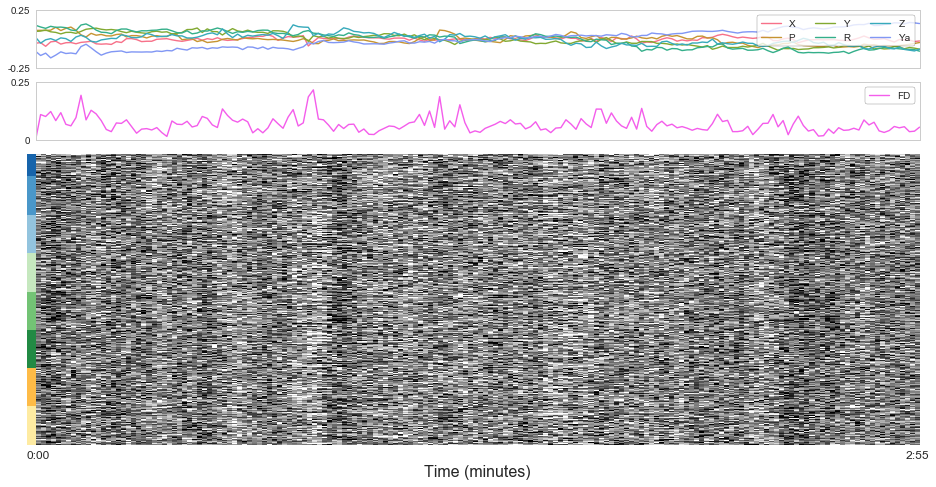

In [4]:
plot = fMRIPlot(func_img, mask_img, tr=2.,
                conf_df=conf_df, seg_nii=seg_img)

fig = plt.figure(figsize=(16, 8))
fig = plot.plot(figure=fig)
fig.tight_layout()
fig.savefig('sandbox/temp.png', dpi=400)